# CPU Over-Allocation (GCP)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.stats as stats
import pickle
import os
import re
import json
import random
from collections import defaultdict, Counter
import matplotlib.ticker as ticker


In [2]:
print("="*80)
print("CPU Over-Allocation (GCP)")
print("-"*80)

CPU Over-Allocation (GCP)
--------------------------------------------------------------------------------


In [3]:
# ensure figures dir exists
os.makedirs('figures', exist_ok=True)

## Read Execution Logs

In [4]:
EXECUTION_LOGS_DIR = '../dataset/cpu_overallocation/gcp'

In [5]:
logs_data = {}
for filename in os.listdir(EXECUTION_LOGS_DIR):
    if filename.endswith('.json'):
        with open(os.path.join(EXECUTION_LOGS_DIR, filename), 'r') as f:
            logs_data[filename[:-5]] = json.load(f)

In [6]:
data_server = {}
data_client = {}
for key, value in logs_data.items():
    vcpu_size = float(re.search(r'\d+\.\d+', key).group())
    if vcpu_size not in data_server:
        data_server[vcpu_size] = []
    if vcpu_size not in data_client:
        data_client[vcpu_size] = []
    data_server[vcpu_size] += value['server']
    data_client[vcpu_size] += value['client']

In [7]:
def parse_logentry(log_entry: str) -> dict:
    latency_match = re.search(r"'latency': '([\d.]+)s'", log_entry)
    duration_ms = float(latency_match.group(1)) * 1000 if latency_match else None
    
    trace_match = re.search(r'/traces/([a-f0-9]+)', log_entry)
    trace_id = trace_match.group(1) if trace_match else None
    
    return {
        'Duration': duration_ms,
        'trace_id': trace_id
    }

In [8]:
def parse_header(header: str) -> dict:
    trace_match = re.search(r"'x-cloud-trace-context': ['\"]([a-f0-9]+)['\"]", header)
    trace_id = trace_match.group(1) if trace_match else None
    
    return {
        'trace_id': trace_id
    }

In [9]:
def parse_payload(payload):
    try:
        parts = payload.strip('"').split('+')

        init_time = int(parts[0])
        CPU_model = parts[1]
        latency = int(parts[3]) - int(parts[2])

        return {
            "init_time": init_time,
            "cpu": CPU_model,
            "measured_latency": latency / 1e6 # convert to milliseconds
        }
    except:
        return {
            "error": "Failed to parse payload",
        }


In [10]:
data_client = {k: [x|parse_payload(x['Payload'])|parse_header(x['Headers']) for x in v] for k, v in data_client.items()}

In [11]:
data_server = {k: [parse_logentry(x) for x in v] for k, v in data_server.items()}

In [12]:
data = {}

data_client_dict = {k: {client_entry['trace_id']: client_entry for client_entry in data_client[k]} for k in data_client}

for k in data_server.keys():
    if k not in data:
        data[k] = []

    client_dict = data_client_dict.get(k, {})

    for server_log_entry in data_server[k]:
        trace_id = server_log_entry['trace_id']

        client_entry = client_dict.get(trace_id)

        if client_entry:
            merged_entry = {**client_entry, **server_log_entry}
            data[k].append(merged_entry)

In [13]:
for k in data.keys():
    data[k] = [x for x in data[k] if 'error' not in x]

## Plotting

In [14]:
def get_execution_duration_proportion_based(cpu_time, vCPUs):
    return cpu_time / vCPUs

In [15]:
required_cpu_time_list = [x['Duration'] for x in data[1]]

In [16]:
gcf_vcpu_list = list(data.keys())
gcf_vcpu_list.sort()
vcpu_vs_avg_execution_duration_pair_list_by_gcf = [(vcpu, np.mean([x['Duration'] for x in data[vcpu]])) for vcpu in gcf_vcpu_list]

In [17]:
vcpu_vs_execution_duration_pair_list_by_proportion = [(vcpu, get_execution_duration_proportion_based(np.mean(required_cpu_time_list), vcpu)) for vcpu in gcf_vcpu_list]
vcpu_vs_execution_duration_pair_list_by_proportion_p5_quantile = [(vcpu, get_execution_duration_proportion_based(np.percentile(required_cpu_time_list, 5), vcpu)) for vcpu in gcf_vcpu_list]
vcpu_vs_execution_duration_pair_list_by_proportion_p95_quantile = [(vcpu, get_execution_duration_proportion_based(np.percentile(required_cpu_time_list, 95), vcpu)) for vcpu in gcf_vcpu_list]

In [18]:
scatter_x = []
scatter_y = []
for vcpu, value in data.items():
    if vcpu > 1:
        continue
    scatter_x += [vcpu] * len(value)
    scatter_y += [x['Duration'] for x in value]

In [19]:
def draw_vertical_double_arrow(
    ax,
    x,
    y_range,
    color='black',
    bar_width=0.01,
    bar_range=None,
    linewidth=1,
    linestyle='solid',
    zorder=5
):
    y_start, y_end = y_range

    # Draw the double-headed arrow
    ax.annotate(
        '',
        xy=(x, y_end),
        xytext=(x, y_start),
        arrowprops=dict(
            arrowstyle='<->',
            color=color,
            linewidth=linewidth,
            linestyle=linestyle,
            shrinkA=0,
            shrinkB=0
        ),
        zorder=zorder
    )

    # Determine tick bar x-range
    if bar_range is not None:
        x0, x1 = bar_range
    else:
        x0 = x - bar_width / 2
        x1 = x + bar_width / 2

    # Draw small horizontal ticks at both ends
    for y in (y_start, y_end):
        ax.hlines(
            y,
            x0,
            x1,
            colors=color,
            linewidth=linewidth,
            zorder=zorder
        )


In [20]:
def draw_vertical_measure(
    ax,
    x,
    y_range,
    label,
    color='black',
    bar_width=0.01,
    linewidth=1,
    linestyle='solid',
    zorder=5,
    text_offset=(0.02, 0)
):
    y0, y1 = y_range
    # arrow
    ax.annotate(
        '',
        xy=(x, y1), xytext=(x, y0),
        arrowprops=dict(arrowstyle='<->',
                        color=color,
                        linewidth=linewidth,
                        linestyle=linestyle,
                        shrinkA=0, shrinkB=0),
        zorder=zorder
    )
    # end‐ticks
    for y in (y0, y1):
        ax.hlines(y, x-bar_width/2, x+bar_width/2,
                  colors=color, linewidth=linewidth, zorder=zorder)
    # label
    ymid = 0.5*(y0 + y1)
    ax.text(
        x + text_offset[0], ymid + text_offset[1], label,
        va='center', ha='left',
        bbox=dict(boxstyle='round,pad=0.2',
                  facecolor='white',
                  edgecolor=color,
                  linewidth=linewidth),
        zorder=zorder
    )


Figure saved to 'figures/overallocation_gcp.pdf'


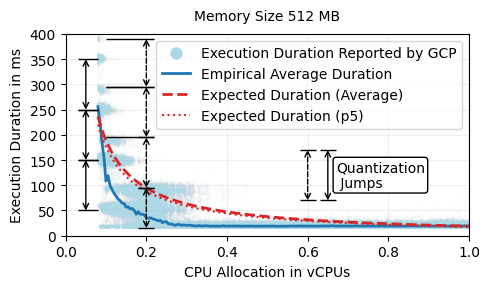

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))

scatter = ax.scatter(
    x=scatter_x,
    y=scatter_y,
    label='Execution Duration Reported by GCP',
    alpha=0.02,
    s=1,
    c='lightblue',
    rasterized=True
)

line_aws = ax.plot(
    [pair[0] for pair in vcpu_vs_avg_execution_duration_pair_list_by_gcf],
    [pair[1] for pair in vcpu_vs_avg_execution_duration_pair_list_by_gcf],
    label='Empirical Average Duration',
    color='tab:blue',
    linestyle='-',
    alpha=1,
    zorder=8,
    linewidth=2
)

line_proportion = ax.plot(
    [pair[0] for pair in vcpu_vs_execution_duration_pair_list_by_proportion],
    [pair[1] for pair in vcpu_vs_execution_duration_pair_list_by_proportion],
    label='Expected Duration (Average)',
    color='tab:red',
    linestyle='dashed',
    alpha=1,
    zorder=10,
    linewidth=2
)

line_proportion2 = ax.plot(
    [pair[0] for pair in vcpu_vs_execution_duration_pair_list_by_proportion_p5_quantile],
    [pair[1] for pair in vcpu_vs_execution_duration_pair_list_by_proportion_p5_quantile],
    label='Expected Duration (p5)',
    color='tab:red',
    linestyle='dotted',
    zorder=10,
    alpha=1
)


custom_scatter = Line2D(
    [0], [0],
    marker='o',
    color='lightblue',
    label='Execution Duration Reported by GCP',
    markersize=8,
    markerfacecolor='lightblue',
    alpha=1,
    linestyle='None'
)

handles, labels = ax.get_legend_handles_labels()

handles = [
    custom_scatter if label == 'Execution Duration Reported by GCP' else handle
    for handle, label in zip(handles, labels)
]

ax.legend(handles=handles, loc='upper right')

ax.set_xlabel('CPU Allocation in vCPUs')
ax.set_ylabel('Execution Duration in ms')

ax.yaxis.set_major_locator(ticker.MultipleLocator(50))

ax.set_xlim(0, 1)
ax.set_ylim(0, 400)
ax.grid(alpha=0.2)

ax.set_title('Memory Size 512 MB', pad=10, fontsize=10)

draw_vertical_double_arrow(ax, x=0.05, y_range=(50, 150), bar_range=(0.03, 0.08), color='black', bar_width=0.03, zorder=20)
draw_vertical_double_arrow(ax, x=0.05, y_range=(150, 250), bar_range=(0.03, 0.08), color='black', bar_width=0.03, zorder=20)
draw_vertical_double_arrow(ax, x=0.05, y_range=(250, 350), bar_range=(0.03, 0.08), color='black', bar_width=0.03, zorder=20)


draw_vertical_double_arrow(ax, x=0.2, y_range=(15, 95), bar_range=(0.18, 0.22), color='black', linestyle='--', bar_width=0.03, zorder=20)
draw_vertical_double_arrow(ax, x=0.2, y_range=(95, 195), bar_range=(0.18, 0.22), color='black', linestyle='--',  bar_width=0.03, zorder=20)
draw_vertical_double_arrow(ax, x=0.2, y_range=(195, 295), bar_range=(0.1, 0.22), color='black', linestyle='--', bar_width=0.03, zorder=20)
draw_vertical_double_arrow(ax, x=0.2, y_range=(295, 390), bar_range=(0.1, 0.22), color='black', linestyle='--', bar_width=0.03, zorder=20)

draw_vertical_measure(
    ax,
    x=0.65,
    y_range=(70, 170),
    label='Quantization\n Jumps',
    color='black',
    bar_width=0.04,
    linewidth=1,
    zorder=10,
    text_offset=(0.02, 0)
)

draw_vertical_measure(
    ax,
    x=0.6,
    y_range=(70, 170),
    label='',
    color='black',
    bar_width=0.04,
    linewidth=1,
    linestyle='--',
    zorder=10,
    text_offset=(0.02, 0)
)

plt.tight_layout()
fig.savefig('figures/overallocation_gcp.pdf')
print("Figure saved to 'figures/overallocation_gcp.pdf'")
plt.show()
